# Chicago bicycle data 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


Importing packages ...

In [1]:
import pandas as pd
import folium
from folium import plugins
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

Reading data file ...

In [2]:
cycle=pd.read_csv('data.csv')

In [3]:
cycle.shape

(9495235, 23)

Seems a lot of data in the file. Lets try to get feel of data by viewing first 5 rows

In [4]:
pd.set_option('display.max_columns', 30)

In [5]:
cycle.head(5)

,trip_id,year,month,week,day,hour,usertype,gender,starttime,stoptime,tripduration,temperature,events,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end
0,2355134,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:57:00,2014-07-01 00:07:00,10.066667,68.0,tstorms,131,Lincoln Ave & Belmont Ave,41.939365,-87.668385,15.0,303,Broadway & Cornelia Ave,41.945512,-87.645980,15.0
1,2355133,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:56:00,2014-07-01 00:00:00,4.383333,68.0,tstorms,282,Halsted St & Maxwell St,41.864580,-87.646930,15.0,22,May St & Taylor St,41.869482,-87.655486,15.0
2,2355130,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:33:00,2014-06-30 23:35:00,2.100000,68.0,tstorms,327,Sheffield Ave & Webster Ave,41.921687,-87.653714,19.0,225,Halsted St & Dickens Ave,41.919936,-87.648830,15.0
3,2355129,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:26:00,2014-07-01 00:24:00,58.016667,68.0,tstorms,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0,194,State St & Wacker Dr,41.887155,-87.627750,11.0
4,2355128,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:16:00,2014-06-30 23:26:00,10.633333,68.0,tstorms,320,Loomis St & Lexington St,41.872187,-87.661501,15.0,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0


As we are only interested in effect of temperature of the trips. We dont need some of the columns. Lets remove those columns so that further computations wont be heavier

In [6]:
cycle=cycle.drop(['stoptime','to_station_id','to_station_name','latitude_end','longitude_end','dpcapacity_start','dpcapacity_end'],axis=1)

Lets add another column which only has start date of the trips. (mostly trip will end on the same day as well)

In [7]:
cycle['starttime'] =  pd.to_datetime(cycle['starttime'], format='%Y-%m-%d %H:%M:%S')
cycle['date']=cycle.starttime.dt.date

Nows lets have a look at all columns we have right now in our data along with their datatypes.

In [8]:
cycle.dtypes

trip_id                       int64
year                          int64
month                         int64
week                          int64
day                           int64
hour                          int64
usertype                     object
gender                       object
starttime            datetime64[ns]
tripduration                float64
temperature                 float64
events                       object
from_station_id               int64
from_station_name            object
latitude_start              float64
longitude_start             float64
date                         object
dtype: object

### Visualizing relation of bicycle trips with the day of week

Grouping by day of week to count number of trips and duration

In [89]:
daycnt=cycle.groupby(cycle['day'])['trip_id'].count()
dayLenAvg=cycle.groupby(cycle['day'])['tripduration'].mean()
days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
daycnt.index=[days[k] for k in daycnt.index]
dayLenAvg.index=[days[k] for k in dayLenAvg.index]

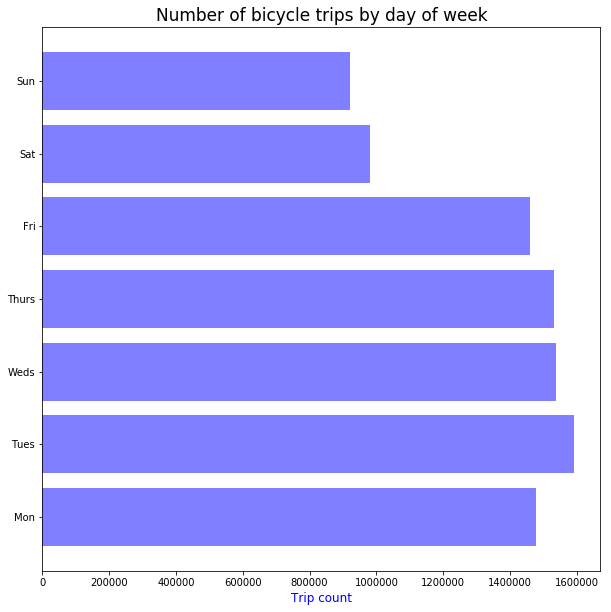

In [12]:
plt.figure(figsize=(10,10))
plt.barh(daycnt.index, daycnt, align='center', alpha=0.5,color='blue')
plt.xlabel('Trip count',fontsize=12,color='Blue')
plt.title('Number of bicycle trips by day of week',fontsize=17)
plt.show()

We have got an interesting result here. As shown in the plot, there are relatively very less number of trips on weekends than weekdays. So, now onwards we can't directly compare all number of trips with any other factors i.e. we will have to compare weekend and weekdays trips separately. 

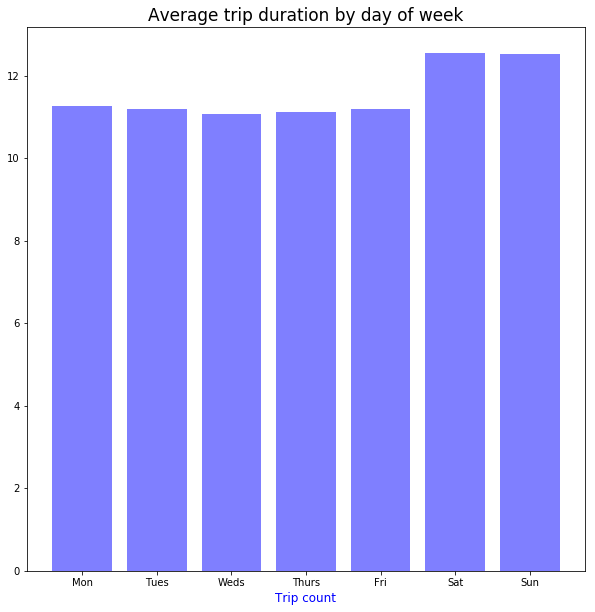

In [135]:
plt.figure(figsize=(10,10))
plt.bar(dayLenAvg.index, dayLenAvg, align='center', alpha=0.5,color='blue')
plt.xlabel('Trip count',fontsize=12,color='Blue')
plt.title('Average trip duration by day of week',fontsize=17)
plt.show()

However, average duration of trips are higher on weekends than that of weekdays. So less people take bicycle rides on weekends. But, the one who takes it tends to relax and take more time for the trips




As decided after previous two graphs, we have to split the data into weekends and weekdays. However, there is another factor. The public holidays are generally there on weekdays, but people tend to behave on those days like weekends.
In the next step, we have to decide if we need to go forward with 2 clusters with holidays are the part of either weekend or should they treated as the 3rd cluster.

In [182]:
cycle.year.unique()

array([2014, 2015, 2016, 2017])

Now lets divide the data in 3 parts. Weekend, weekdays, holidays. As people go out of the city during holidays or plan some activities, the trips wont have same pattern as of weekdays or weekends. So it would be interesting to observe behavior of people during holidays.

In [183]:
holidays_list=['2014-01-01','2014-01-20','2014-02-12','2014-02-17','2014-03-03','2014-05-11','2014-05-26','2014-06-15','2014-07-04','2014-09-01','2014-10-13','2014-11-04','2014-11-11','2014-11-27','2014-11-28','2014-12-25','2014-12-26',
        '2015-01-01','2015-01-19','2015-02-12','2015-02-16','2015-03-02','2015-05-25','2015-06-21','2015-07-03','2015-09-07','2015-10-12','2015-11-11','2015-11-26','2015-11-27','2015-12-25',
          '2016-01-01','2016-01-18','2016-02-12','2016-02-15','2016-03-07','2016-05-08','2016-05-30','2016-06-19','2016-07-04','2016-09-05','2016-10-10','2016-11-08','2016-11-11','2016-11-24','2016-11-24','2016-12-26',
          '2017-01-02','2017-01-16','2017-02-12','2017-02-20','2017-05-14','2017-05-29','2017-06-18','2017-07-04','2017-09-04','2017-10-09','2017-11-10','2017-11-23','2017-11-24','2017-12-25']
holidaysdt=pd.DataFrame(holidays_list,columns=['date'])
holidaysdt['date']=pd.to_datetime(holidaysdt['date'],format='%Y-%m-%d')
holidaysdt['date']=holidaysdt['date'].dt.date
holiday=cycle.merge(holidaysdt,on=['date'])

Source: https://www.officeholidays.com/countries/usa/regional.php?list_year=2017&list_region=illinois

In [16]:
nonHol = pd.concat([cycle, holiday])


In [17]:
nonHol=nonHol.drop_duplicates(keep=False)
nonHol.shape

(9242218, 17)

In [18]:
weekend=nonHol[nonHol['day']>4]
weekday=nonHol[nonHol['day']<=4]


Splited data into 3 clusters

In [19]:
count=[weekday.shape[0],weekend.shape[0],holiday.shape[0]]

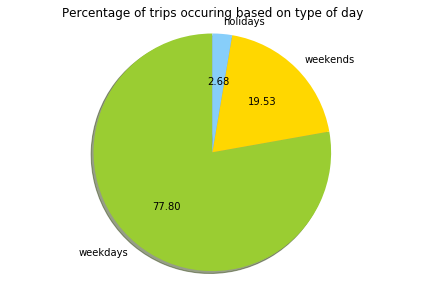

In [195]:
labels = ['weekdays', 'weekends', 'holidays']
colors = ['yellowgreen', 'gold', 'lightskyblue']
plt.pie(count, colors=colors, shadow=True, autopct='%.2f',labels=labels,startangle=90)
plt.axis('equal')
plt.tight_layout()
plt.title('Percentage of trips occuring based on type of day')
plt.show()

There are various reasons which forces us to consider holidays as the 3rd cluster. People might travel more on holidays than weekends due to festivals or some other reasons. Also after looking at the pie-chart, we can conveniently say that almost 3% of trips occure on holidays and merging it to weekends won't be a good idea to get accurate exploration of data.

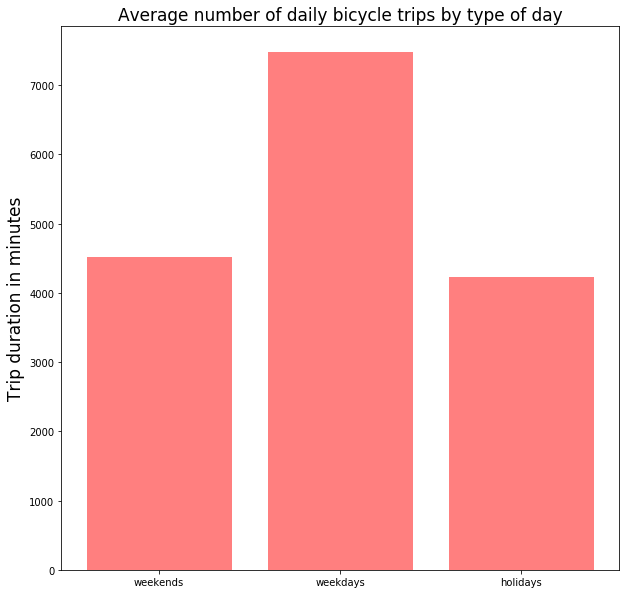

In [188]:
objects = ('weekends', 'weekdays', 'holidays')
y_pos = np.arange(len(objects))
performance = [wkendavg,wkdayavg,holavg]
plt.figure(figsize=(10,10))
plt.bar(y_pos, performance, align='center', alpha=0.5,color='red',width=0.8)
plt.xticks(y_pos, objects)
plt.ylabel('Trip duration in minutes',fontsize=17)
plt.title('Average number of daily bicycle trips by type of day',fontsize=17)
plt.show()

Surprisingly, there are comparable number of trips of holidays with weekends. On weekdays, there are very high number of trips which suggest that, bicycle has become routine part of chicago.

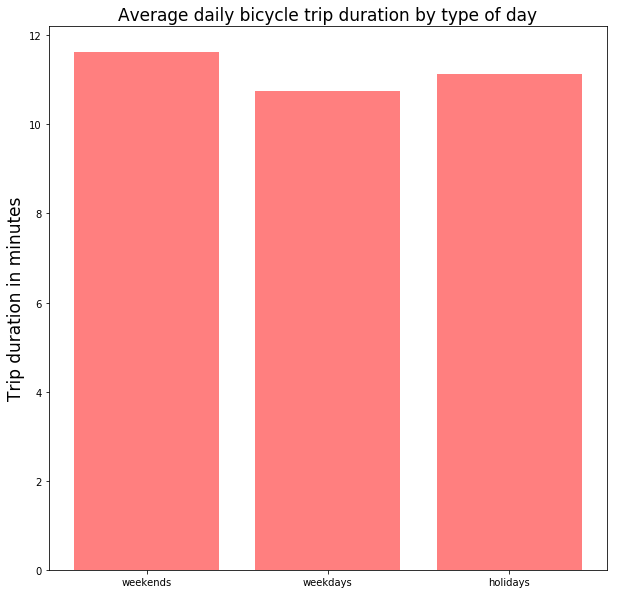

In [187]:
objects = ('weekends', 'weekdays', 'holidays')
y_pos = np.arange(len(objects))
performance = [wkendLenAvg,wkdayLenAvg,holLenAvg]
plt.figure(figsize=(10,10))
plt.bar(y_pos, performance, align='center', alpha=0.5,color='red',width=0.8)
plt.xticks(y_pos, objects)
plt.ylabel('Trip duration in minutes',fontsize=17)
plt.title('Average daily bicycle trip duration by type of day',fontsize=17)
plt.show()

With the duration of trips, the same thing is observed here. People take less rides on holidays and weekends. But, they take more time to reach destination as compared to weekdays. 

### Bicycle trip analysis for genders

In [123]:
male=cycle[cycle['gender']=='Male']
female=cycle[cycle['gender']=='Female']

In [124]:
gendCount=[male.shape[0],female.shape[0]]

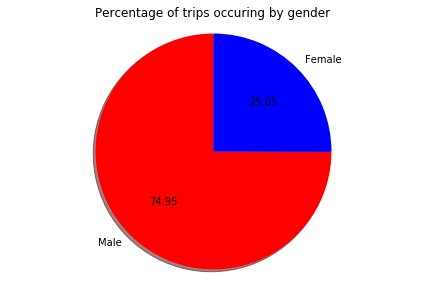

In [196]:
labels = ['Male', 'Female']
colors = ['Red', 'Blue']
plt.pie(gendCount, colors=colors, shadow=True, autopct='%.2f',labels=labels,startangle=90)
plt.axis('equal')
plt.tight_layout()
plt.title('Percentage of trips occuring by gender')

plt.show()

Almost 3/4th of total bicycle trips are taken by male.

In [133]:
maleLen=cycle[cycle['gender']=='Male']['tripduration'].mean()
femaleLen=cycle[cycle['gender']=='Female']['tripduration'].mean()

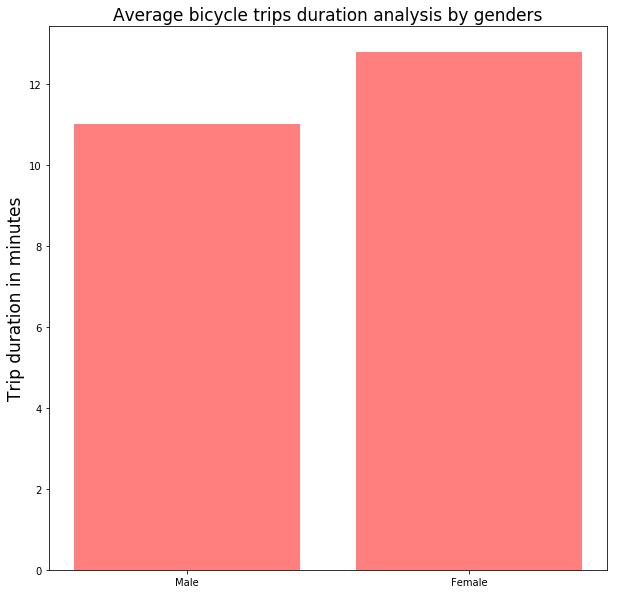

In [186]:
objects = ('Male', 'Female')
y_pos = np.arange(len(objects))
performance = [maleLen,femaleLen]
plt.figure(figsize=(10,10))
plt.bar(y_pos, performance, align='center', alpha=0.5,color='R',width=0.8)
plt.xticks(y_pos, objects)
plt.ylabel('Trip duration in minutes',fontsize=17)
plt.title('Average bicycle trips duration analysis by genders',fontsize=17)
plt.show()

But, when we compare trip duration of males and females, we observe that females take almost a minute more than males to reach destination

In [21]:
wkendavg=(weekend.groupby(weekend['date'])['trip_id'].count()).mean()
wkdayavg=(weekday.groupby(weekday['date'])['trip_id'].count()).mean()
holavg=(holiday.groupby(holiday['date'])['trip_id'].count()).mean()

In [87]:
wkendLenAvg=(weekend.groupby(weekend['date'])['tripduration'].mean()).mean()
wkdayLenAvg=(weekday.groupby(weekday['date'])['tripduration'].mean()).mean()
holLenAvg=(holiday.groupby(holiday['date'])['tripduration'].mean()).mean()

Seems like weekdays have most number of users as expected. Whereas, during holidays the average number of trips per day is almost same as weekends. But, we can't directly conclude anything by only this graph. We will have to consider other factors such as environmental events, temperature.

### Effect of environmental events on bicycle trips

In [ ]:
dfs = dict(tuple(cycle.groupby('events')))

In [193]:
l=[]
eveSize=[]
for k in dfs:
    l.append(str(k))
    eveSize.append(dfs[k].shape[0])

Splited dataframe by grouping and stored in the dictionary. So that dataframe names and other attributed are dynamically used.

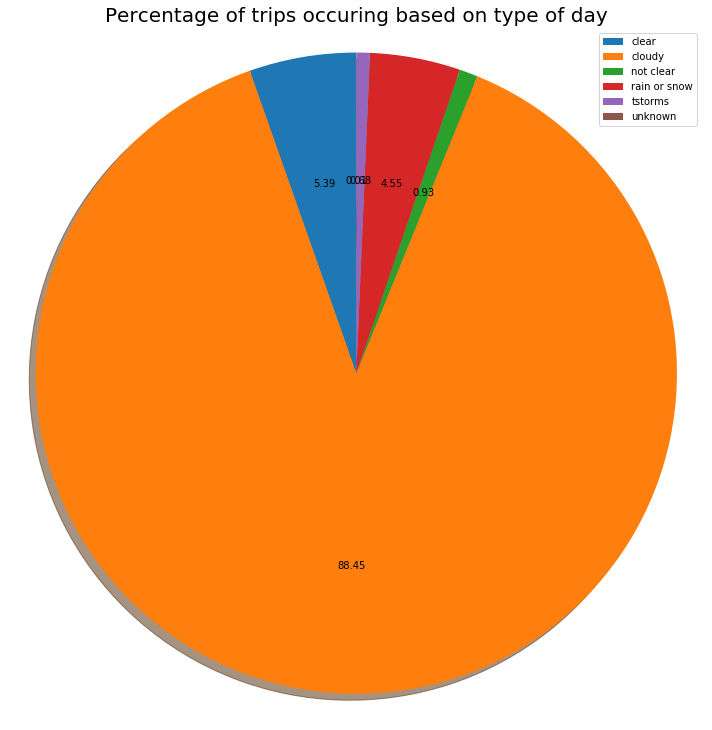

In [215]:
fig = plt.figure(figsize=[10, 10])
plt.pie(eveSize, shadow=True, autopct='%.2f',startangle=90)
plt.axis('equal')
plt.tight_layout()
plt.legend(labels=l,)
plt.title('Percentage of trips occuring based on type of day',fontsize=20)
plt.show()

We can observe most number of trips are happening when weather is cloudy. The reason is most of time the weather is cloudy. As, all the events wont appear in the equal proportion, grouping by just event won't give reliable results. So, the total number of trips are again divided by their respective number of days to normalize the data. 

In [191]:
eventavg=(cycle.groupby(['events','date'])['trip_id'].count()).groupby(['events']).mean()
eventLenAvg=(cycle.groupby(['events'])['tripduration'].mean())

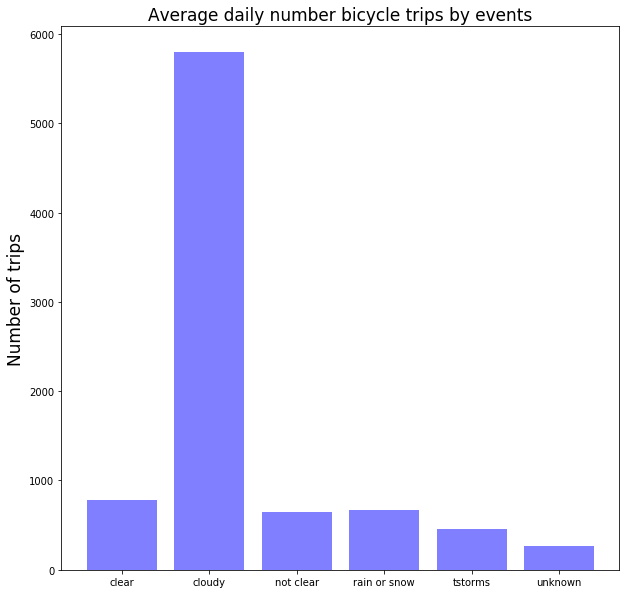

In [251]:
y_pos = np.arange(len(eventavg.index))
plt.figure(figsize=(10,10))
plt.bar(y_pos, eventavg, align='center', alpha=0.5,color='Blue',width=0.8)
plt.xticks(y_pos, eventavg.index)
plt.ylabel('Number of trips',fontsize=17)
plt.title('Average daily number bicycle trips by events',fontsize=17)
plt.show()

As per as number of trips are concerned, people tend to took a lot of trips when weather is cloudy. It is surprising that when weather is clear, number of trips are still lesser. May be during peak hours, clear weather is rare.

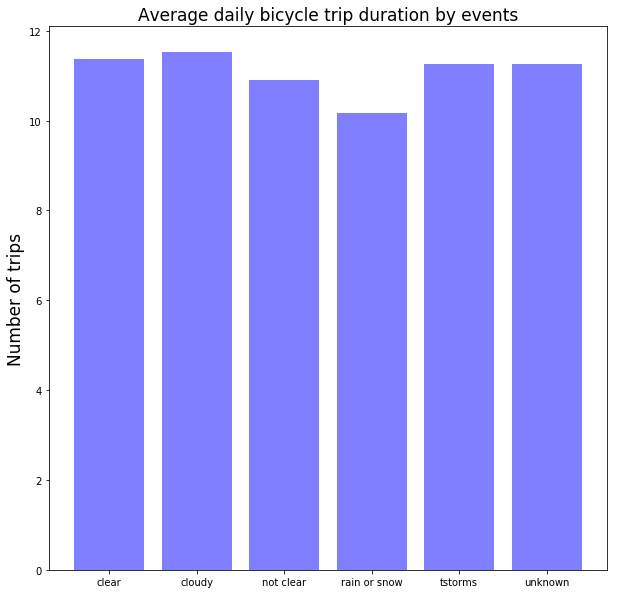

In [94]:
y_pos = np.arange(len(eventLenAvg.index))
plt.figure(figsize=(10,10))
plt.bar(y_pos, eventLenAvg, align='center', alpha=0.5,color='Blue',width=0.8)
plt.xticks(y_pos, eventLenAvg.index)
plt.ylabel('Number of trips',fontsize=17)
plt.title('Average daily bicycle trip duration by events',fontsize=17)
plt.show()

Environmental events don't have much effect on duration of trips. All the trips are between 10 to 12 minutes. But, as expected, during snow and rain trip duration is slighly less.

In [13]:
cycle.temperature.max(),cycle.temperature.min()

(95.0, -15.0)

Chicago has great range of temperatures

In [25]:
wkdayeventavg=(weekday.groupby(['events','date'])['trip_id'].count()).groupby(['events']).mean()
wkendeventavg=(weekend.groupby(['events','date'])['trip_id'].count()).groupby(['events']).mean()
holeventavg=(holiday.groupby(['events','date'])['trip_id'].count()).groupby(['events']).mean()

In [26]:
wkdayeventavg

events
clear            871.216590
cloudy          6646.552391
not clear        937.835443
rain or snow     779.476510
tstorms          505.590476
unknown          268.000000
Name: trip_id, dtype: float64

In [27]:
wkendeventavg

events
clear            635.211055
cloudy          4017.071253
not clear        214.160000
rain or snow     436.771084
tstorms          289.529412
Name: trip_id, dtype: float64

In [28]:
holeventavg

events
clear            304.250000
cloudy          3915.745763
not clear        420.250000
rain or snow     374.066667
tstorms          404.000000
Name: trip_id, dtype: float64

In [29]:
(weekday[weekday['events']=='unknown']).shape

(536, 17)

Unknown event is only appearing during weekdays. So, for comparison let's just ignore that event. It won't affect much as frequency of that event is very less anyway.

In [30]:
weekdaycln=(weekday[weekday['events']!='unknown'])

In [31]:
wkdayclneventavg=(weekdaycln.groupby(['events','date'])['trip_id'].count()).groupby(['events']).mean()

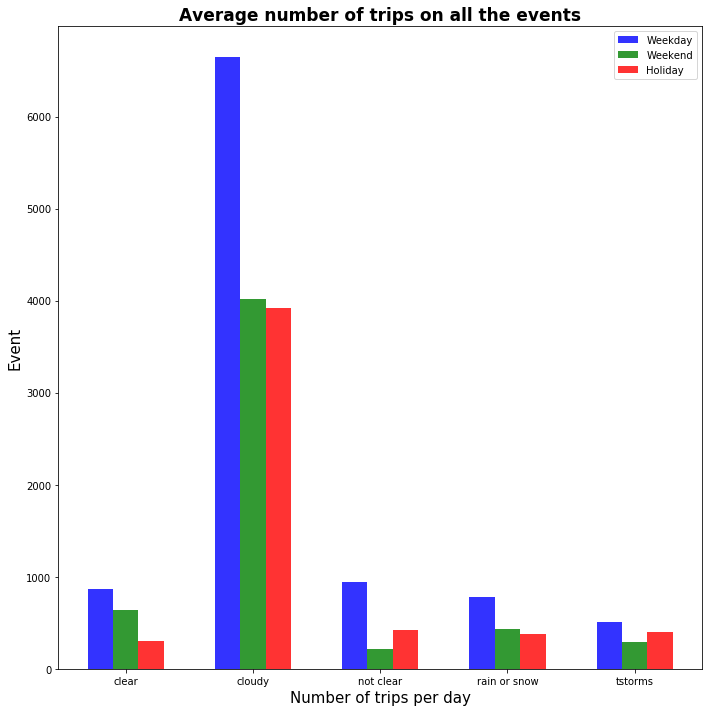

In [219]:
n_groups = len(wkdayclneventavg.index)
 
plt.figure(figsize=(10,10))
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8
 
plt.bar(index, wkdayclneventavg, bar_width,
alpha=opacity,
color='b',
label='Weekday')
 
plt.bar(index + bar_width,wkendeventavg,  bar_width,
alpha=opacity,
color='g',
label='Weekend')

plt.bar(index + 2*bar_width, holeventavg, bar_width,
alpha=opacity,
color='r',
label='Holiday')

plt.xlabel('Number of trips per day',fontsize=15)
plt.ylabel('Event',fontsize=15)
plt.title('Average number of trips on all the events',fontsize=17,fontweight='bold')
plt.xticks(index + bar_width,wkendeventavg.index )
plt.legend()
 
plt.tight_layout()
plt.show()

So events have almost same behavioral trend on all the days. Except, during weekends and when weather is not clear or stormy, people prefer to stay at their places. While during same weather and holidays, people go out more often than weekends.

### Relation of temperature with trips

In [223]:
wkdaytmp=(weekday.groupby(['temperature','date'])['trip_id'].count()).groupby(['temperature']).mean()
wkendtmp=(weekend.groupby(['temperature','date'])['trip_id'].count()).groupby(['temperature']).mean()
holtmp=(holiday.groupby(['temperature','date'])['trip_id'].count()).groupby(['temperature']).mean()


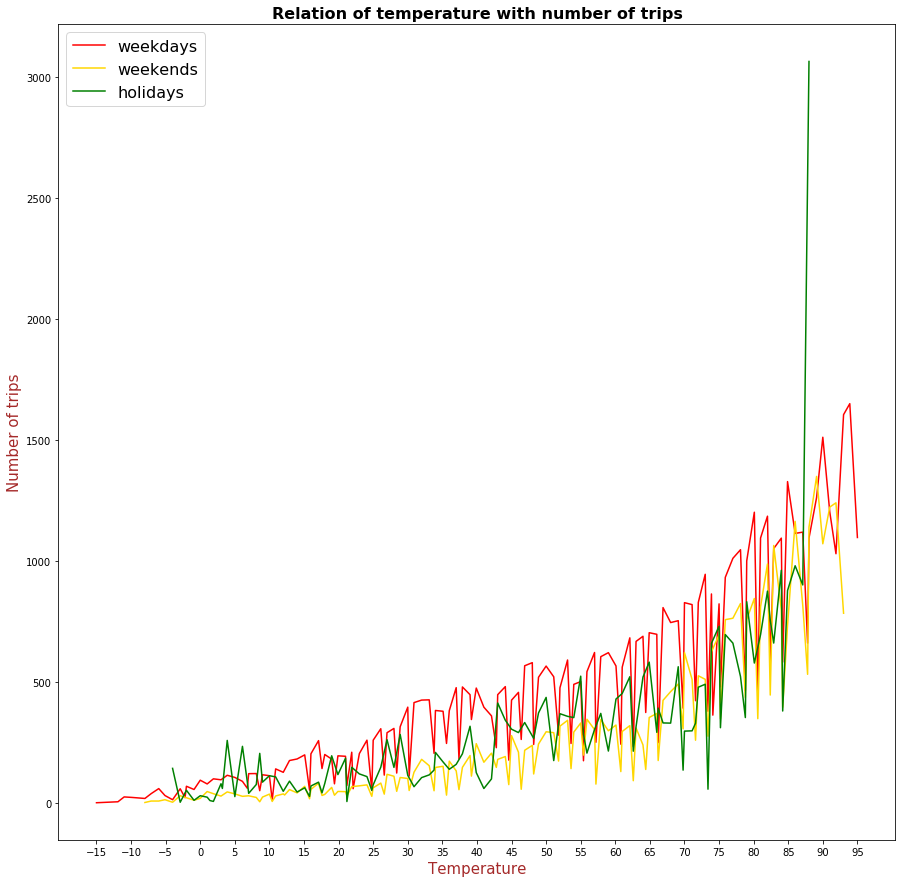

In [224]:
plt.figure(figsize=(15,15))
plt.plot(wkdaytmp.index,wkdaytmp,color='R',label='weekdays')
plt.plot(wkendtmp.index,wkendtmp,color='gold',label='weekends')
plt.plot(holtmp.index,holtmp,color='g',label='holidays')
plt.title("Relation of temperature with number of trips", fontsize=16, fontweight='bold')
plt.xlabel("Temperature",fontsize=15,color='brown')
plt.ylabel("Number of trips",fontsize=15,color='brown')
plt.legend(loc="upper left",prop={'size': 16})
plt.xticks(np.arange(min(cycle['temperature']),max(cycle['temperature'])+1,5))
plt.show()

Clearly evident that, temperature plays a big role in number of trips. As temperature increases number of average number of trips of per for particular temperature also increases. When temperature is below 50, there is big difference in number of trips during weekdays and weekdays as well as holidays. In lower temperature, if they dont have routine, people dont go out and use bicycles. While during weekdays, people are forced to use bicycles due to routine. Again proving that bicycle is a part of routine for people of chicago.

In [221]:
wkdaytmpavg=(weekday.groupby(['temperature'])['tripduration'].mean())
wkendtmpavg=(weekend.groupby(['temperature'])['tripduration'].mean())
holtmpavg=(holiday.groupby(['temperature'])['tripduration'].mean())

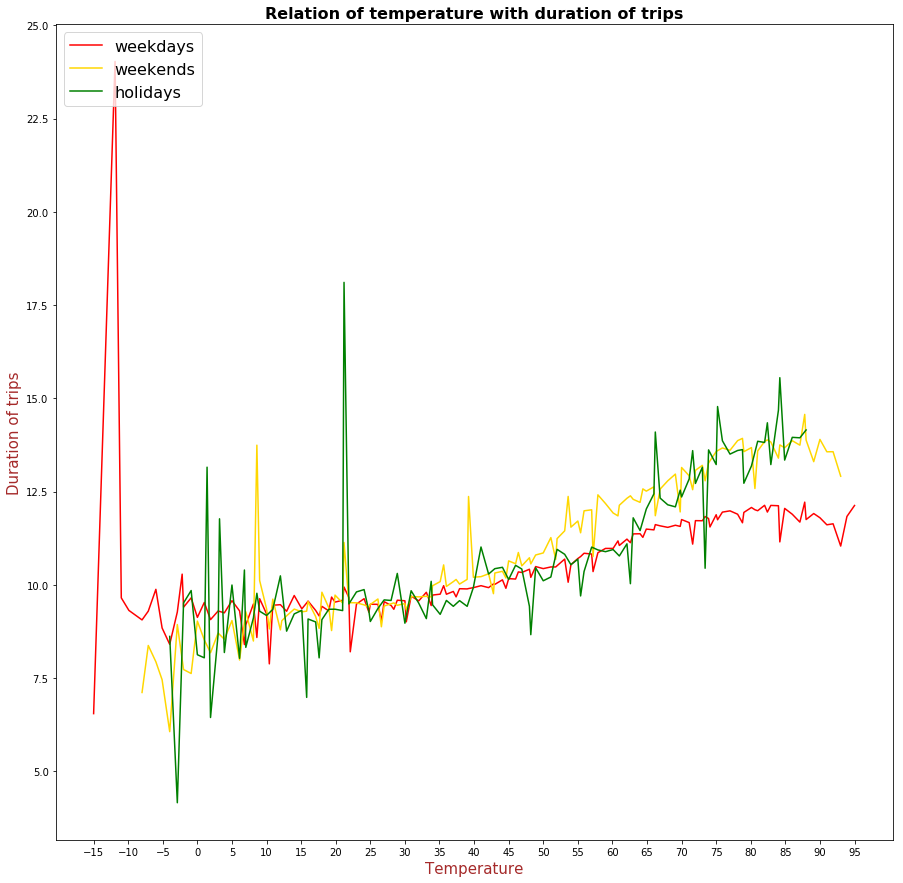

In [222]:
plt.figure(figsize=(15,15))
plt.plot(wkdaytmpavg.index,wkdaytmpavg,color='R',label='weekdays')
plt.plot(wkendtmpavg.index,wkendtmpavg,color='gold',label='weekends')
plt.plot(holtmpavg.index,holtmpavg,color='g',label='holidays')
plt.title("Relation of temperature with duration of trips", fontsize=16, fontweight='bold')
plt.xlabel("Temperature",fontsize=15,color='brown')
plt.ylabel("Duration of trips",fontsize=15,color='brown')
plt.legend(loc="upper left",prop={'size': 16})
plt.xticks(np.arange(min(cycle['temperature']),max(cycle['temperature'])+1,5))
plt.show()

Though number of trips are slightly lesses of weekends and holidays than weekdays, duration of trip during weekends and holidays is more than weekdays for higher temperature. During weekend when temperature is low (less than 32), even if people take trips, they dont seem to last as long as they do when temperature is high 

In [35]:
cycle.usertype.unique()

array(['Subscriber', 'Customer', 'Dependent'], dtype=object)

In [36]:
subsr=cycle[cycle['usertype']=='Subscriber']
cust=cycle[cycle['usertype']=='Customer']
depnd=cycle[cycle['usertype']=='Dependent']

In [37]:
subsctemp=(subsr.groupby(['temperature'])['trip_id'].count())
custtemp=(cust.groupby(['temperature'])['trip_id'].count())
depndtemp=(depnd.groupby(['temperature'])['trip_id'].count())

In [38]:
subsr.shape

(9493780, 17)

In [39]:
cust.shape

(1277, 17)

In [40]:
depnd.shape

(178, 17)

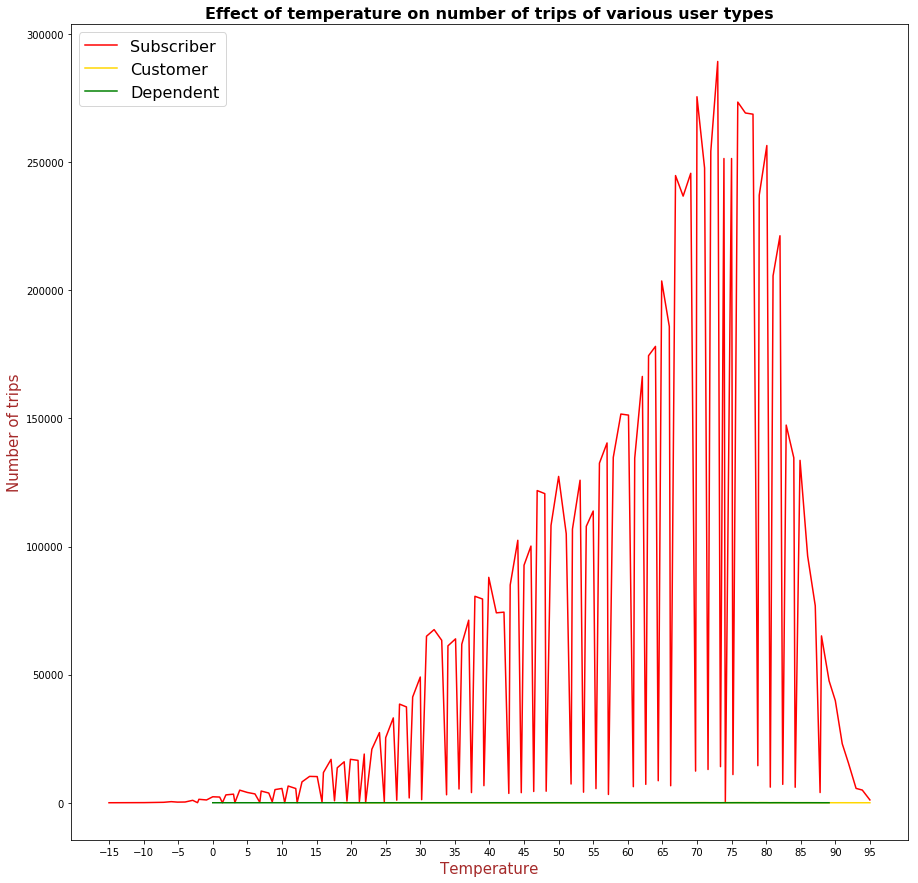

In [225]:
plt.figure(figsize=(15,15))
plt.plot(subsctemp.index,subsctemp,color='R',label='Subscriber')
plt.plot(custtemp.index,custtemp,color='gold',label='Customer')
plt.plot(depndtemp.index,depndtemp,color='g',label='Dependent')
plt.title("Effect of temperature on number of trips of various user types", fontsize=16, fontweight='bold')
plt.xlabel("Temperature",fontsize=15,color='brown')
plt.ylabel("Number of trips",fontsize=15,color='brown')
plt.legend(loc="upper left",prop={'size': 16})
plt.xticks(np.arange(min(cycle['temperature']),max(cycle['temperature'])+1,5))
plt.show()

The same trend is followed by people who have subscribed with yearly pass. They take more trips as temperature increases.<br>
Trends of daily customers and dependants can't be compared as their number is very less as compared to subscribers. So Lets visualize their behavior with the temperature using separate graphs.

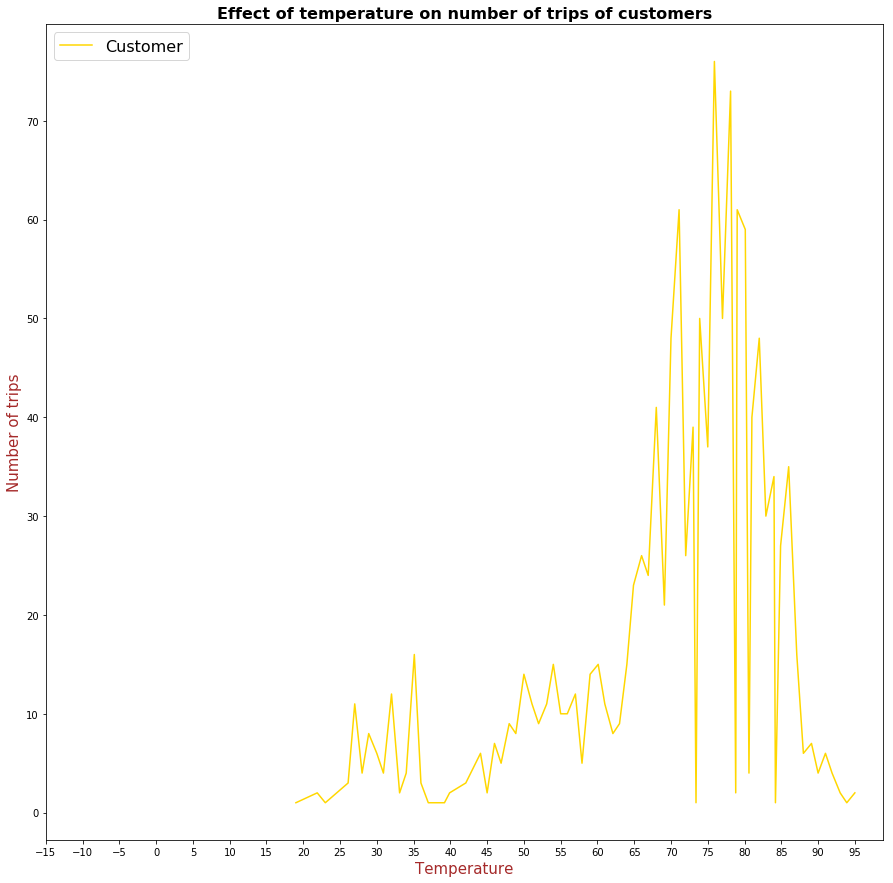

In [252]:
plt.figure(figsize=(15,15))
plt.plot(custtemp.index,custtemp,color='gold',label='Customer')
plt.title("Effect of temperature on number of trips of customers", fontsize=16, fontweight='bold')
plt.xlabel("Temperature",fontsize=15,color='brown')
plt.ylabel("Number of trips",fontsize=15,color='brown')
plt.legend(loc="upper left",prop={'size': 16})
plt.xticks(np.arange(min(cycle['temperature']),max(cycle['temperature'])+1,5))
plt.show()

People who take daily pass don't go out at all, to use bicycles when temperature is low. So, people who want to go out for every weather conditions and during all the seasons take yearly subscription.

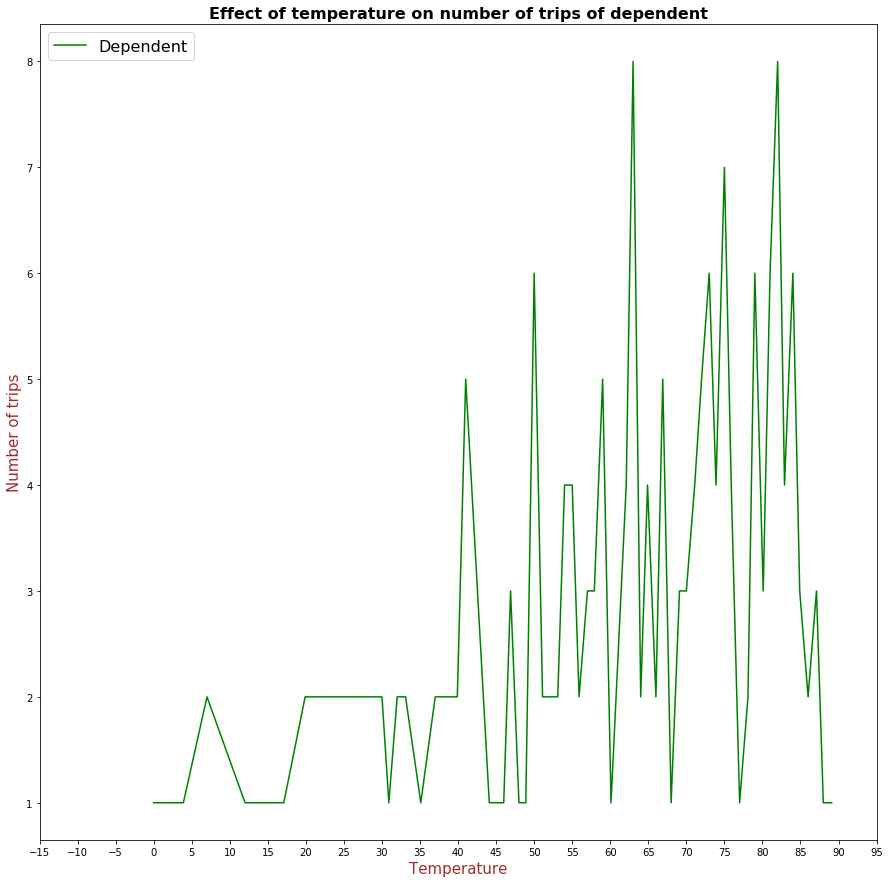

In [226]:
plt.figure(figsize=(15,15))
plt.plot(depndtemp.index,depndtemp,color='g',label='Dependent')
plt.title("Effect of temperature on number of trips of dependent", fontsize=16, fontweight='bold')
plt.xlabel("Temperature",fontsize=15,color='brown')
plt.ylabel("Number of trips",fontsize=15,color='brown')
plt.legend(loc="upper left",prop={'size': 16})
plt.xticks(np.arange(min(cycle['temperature']),max(cycle['temperature'])+1,5))
plt.show()

Number of dependent people are very less. Due to unavailability of enough data, trends of dependent people can't be predicted.

As, number of subscribers dominate other user types, comparing their behavior for duration of trips with temperature wont give any conclusive evidence. However, we can directly compare their trip trip during without considering temperature factor

In [232]:
usrlen=cycle.groupby('usertype')['tripduration'].mean()

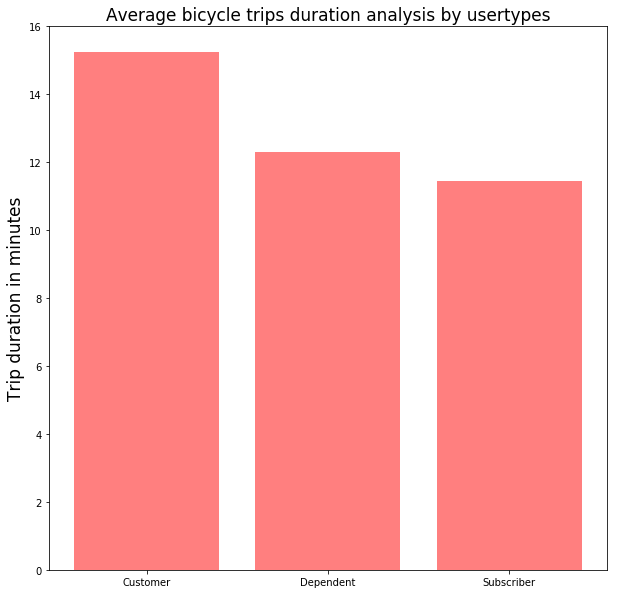

In [253]:
objects=usrlen.index
y_pos = np.arange(len(objects))
plt.figure(figsize=(10,10))
plt.bar(y_pos, usrlen, align='center', alpha=0.5,color='R',width=0.8)
plt.xticks(y_pos, objects)
plt.ylabel('Trip duration in minutes',fontsize=17)
plt.title('Average bicycle trips duration analysis by usertypes',fontsize=17)
plt.show()

Event though, subscribers take more trips, dependent and customers seem to enjoy trips more. As, they take trips for longer time

In [237]:
label=[]
data=[]
for key in dfs:
    dfs1 = dict(tuple(dfs[key].groupby('gender')))
    for key1 in dfs1:
        data.append(dfs1[key1]['temperature'])
        lab=str(key1)+'s in '+str(key)
        label.append(lab)
        

/home/shreyas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


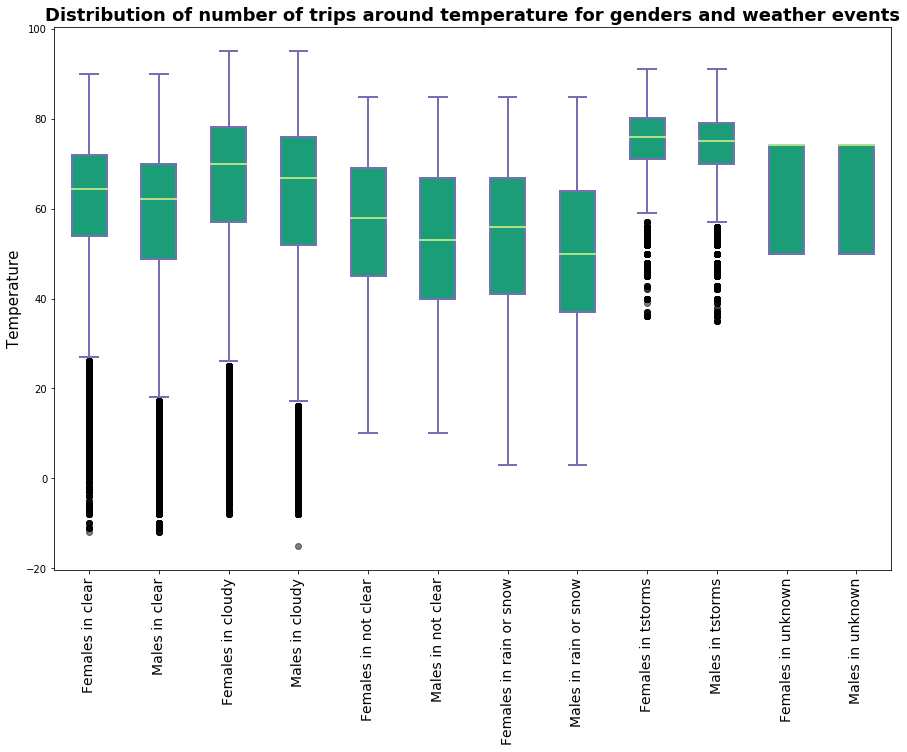

In [238]:
# Create a figure instance
fig = plt.figure(1, figsize=(15, 10))
ax = fig.add_subplot(111)
bp = ax.boxplot(data, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)
ax.set_ylabel('Temperature',fontsize=15)
ax.set_title('Distribution of number of trips around temperature for genders and weather events',fontsize=18,fontweight='bold')
ax.set_xticklabels(label,rotation='vertical',fontsize=14)
plt.show()

In any weather event, females prefer to take trips on higher temperatures than males which can be seen by medians and quartile distribution. In the storms, user only go out to take trips when temperature is higher. <br>
<br>
Events are proportional to the temperature and so we can't directly compare temperature ranges of various events. As, during rain and snow, if people are taking the trips, the median value will be lower and so the temperature isn't preference in some weather events. Still, by median value, the general trend of people for particular weather event can be concluded from above box plots. <br>
To sum up, from above box plot, we can say during any weather condition, given the temperature range of the event, people take more trips when temperature is high.

### Seasonality in the trips

In [155]:
mon=cycle.groupby(['month'])['trip_id'].count()
monMean=cycle.groupby(['month'])['tripduration'].mean()
month={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}
mon.index=[month[k] for k in mon.index]
monMean.index=[month[k] for k in monMean.index]

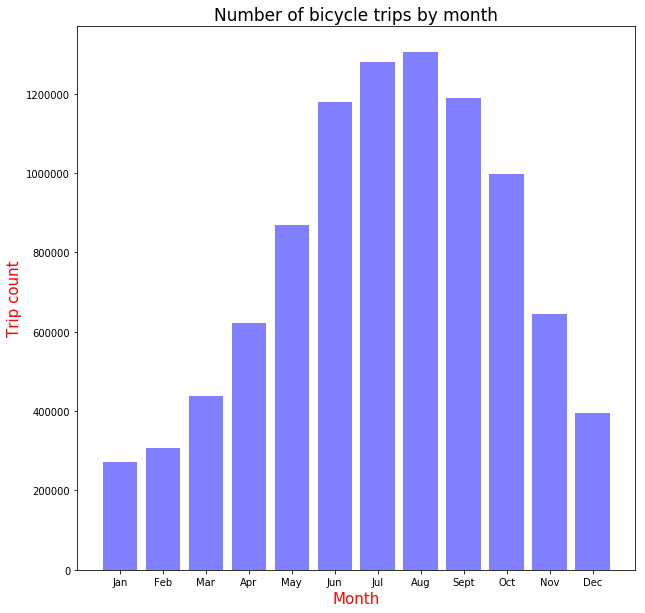

In [102]:
plt.figure(figsize=(10,10))
plt.bar(mon.index, mon, align='center', alpha=0.5,color='blue')
plt.ylabel('Trip count',fontsize=15,color='Red')
plt.xlabel('Month',fontsize=15,color='Red')

plt.title('Number of bicycle trips by month',fontsize=17)
plt.show()

During summer and fall, more number of trips are taken

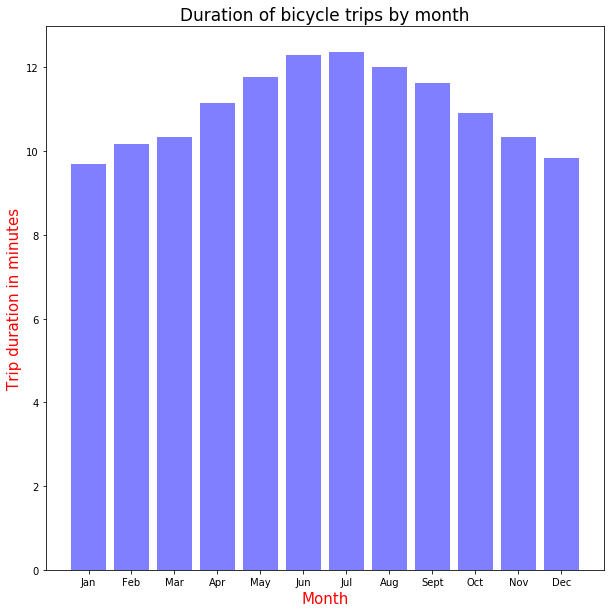

In [254]:
plt.figure(figsize=(10,10))
plt.bar(monMean.index, monMean, align='center', alpha=0.5,color='blue')
plt.ylabel('Trip duration in minutes',fontsize=15,color='Red')
plt.xlabel('Month',fontsize=15,color='Red')
plt.title('Duration of bicycle trips by month',fontsize=17)
plt.show()

Trip duration also increases in summer and fall. But, the change isn't drastic.

In [242]:
maleDate=cycle[cycle['gender']=='Male'].groupby(['date']).size()
femaleDate=cycle[cycle['gender']=='Female'].groupby(['date']).size()

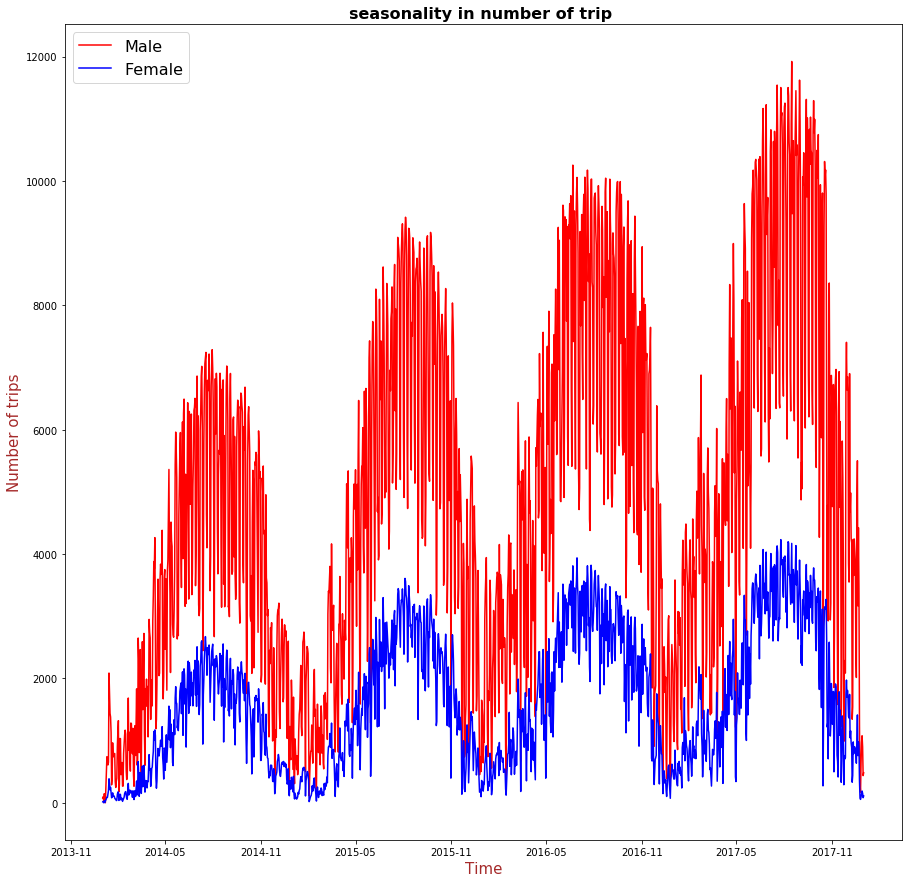

In [243]:
plt.figure(figsize=(15,15))
plt.plot(maleDate.index,maleDate,color='R',label='Male')
plt.plot(femaleDate.index,femaleDate,color='B',label='Female')
plt.title("seasonality in number of trip ", fontsize=16, fontweight='bold')
plt.xlabel("Time",fontsize=15,color='brown')
plt.ylabel("Number of trips",fontsize=15,color='brown')
plt.legend(loc="upper left",prop={'size': 16})

plt.show()

The same seasonality is observed in the above time-series plot. For all 4 years, number of trips are at their peak during summer and lowest during winter. The graph show seasonality with increasing trend. By which we can also conclude that, number of trips are increasing every year.
Also, other thing which we can observe here is, male users are increasing in higher proportion than female users. Number of trips for males are also always more than females in all 4 years.

In [244]:
maleLenDate=cycle[cycle['gender']=='Male'].groupby(['date'])['tripduration'].mean()
femaleLenDate=cycle[cycle['gender']=='Female'].groupby(['date'])['tripduration'].mean()

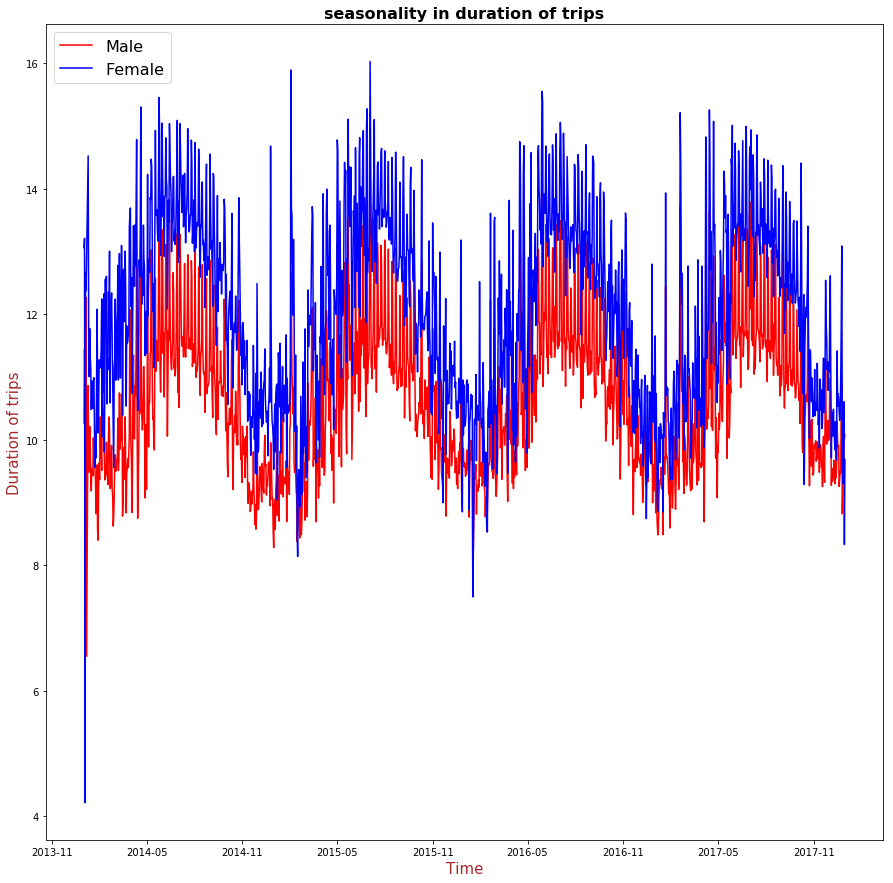

In [245]:
plt.figure(figsize=(15,15))
plt.plot(maleLenDate.index,maleLenDate,color='R',label='Male')
plt.plot(femaleLenDate.index,femaleLenDate,color='B',label='Female')
plt.title("seasonality in duration of trips", fontsize=16, fontweight='bold')
plt.xlabel("Time",fontsize=15,color='brown')
plt.ylabel("Duration of trips",fontsize=15,color='brown')
plt.legend(loc="upper left",prop={'size': 16})

plt.show()

However, average trip duration is consistently higher for female users than male users for all the time.
Trip duration also shows seasonality. Both male and females take bicycle trips for 2 minutes longer in summer than in winter.

In [61]:
subDate=cycle[cycle['usertype']=='Subscriber'].groupby(['date']).size()
custDate=cycle[cycle['usertype']=='Customer'].groupby(['date']).size()

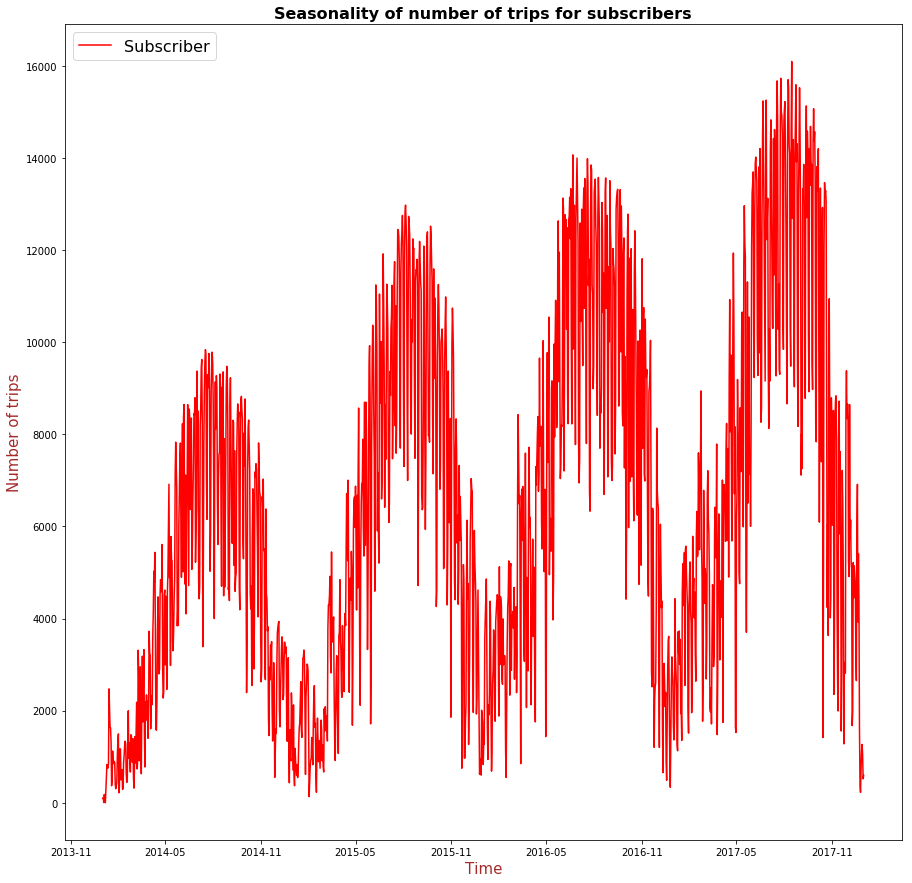

In [247]:
plt.figure(figsize=(15,15))
plt.plot(subDate.index,subDate,color='R',label='Subscriber')
plt.title("Seasonality of number of trips for subscribers", fontsize=16, fontweight='bold')
plt.xlabel("Time",fontsize=15,color='brown')
plt.ylabel("Number of trips",fontsize=15,color='brown')
plt.legend(loc="upper left",prop={'size': 16})

plt.show()

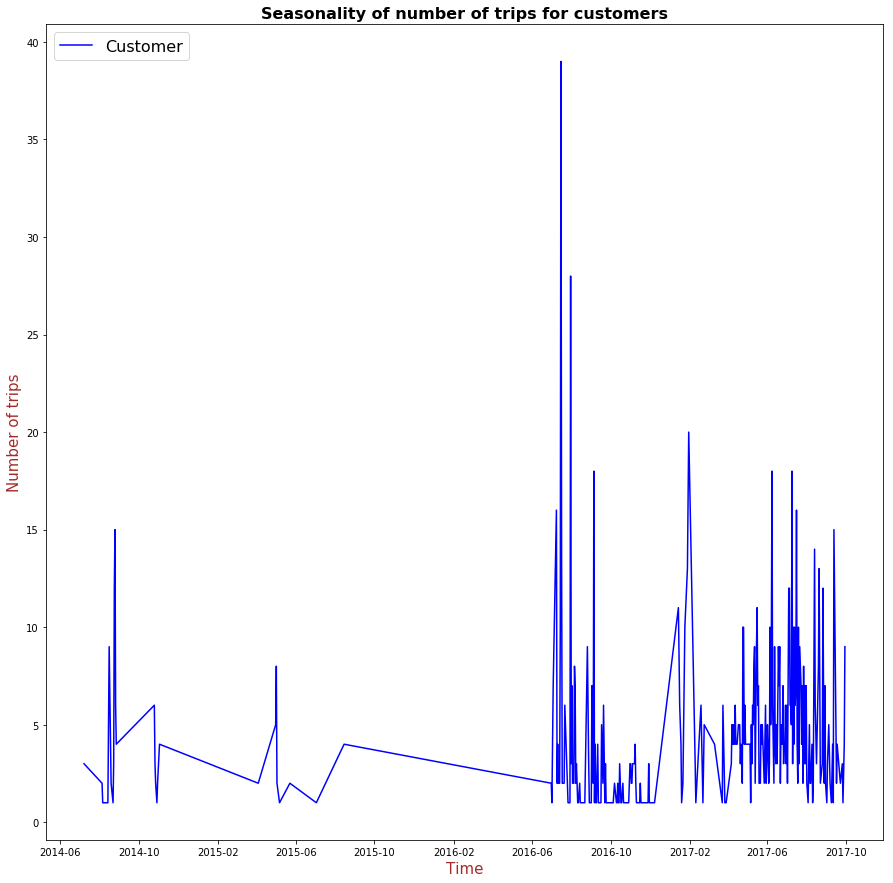

In [255]:
plt.figure(figsize=(15,15))
plt.plot(custDate.index,custDate,color='B',label='Customer')
plt.title("Seasonality of number of trips for customers", fontsize=16, fontweight='bold')
plt.xlabel("Time",fontsize=15,color='brown')
plt.ylabel("Number of trips",fontsize=15,color='brown')
plt.legend(loc="upper left",prop={'size': 16})

plt.show()

Subscribers show similar behavior of what we observed for overall data. While, surprisingly there's no seasonality for customers. Considering dependent users wont give any conclusive results as available data in insufficient to observe trend for 4 years.

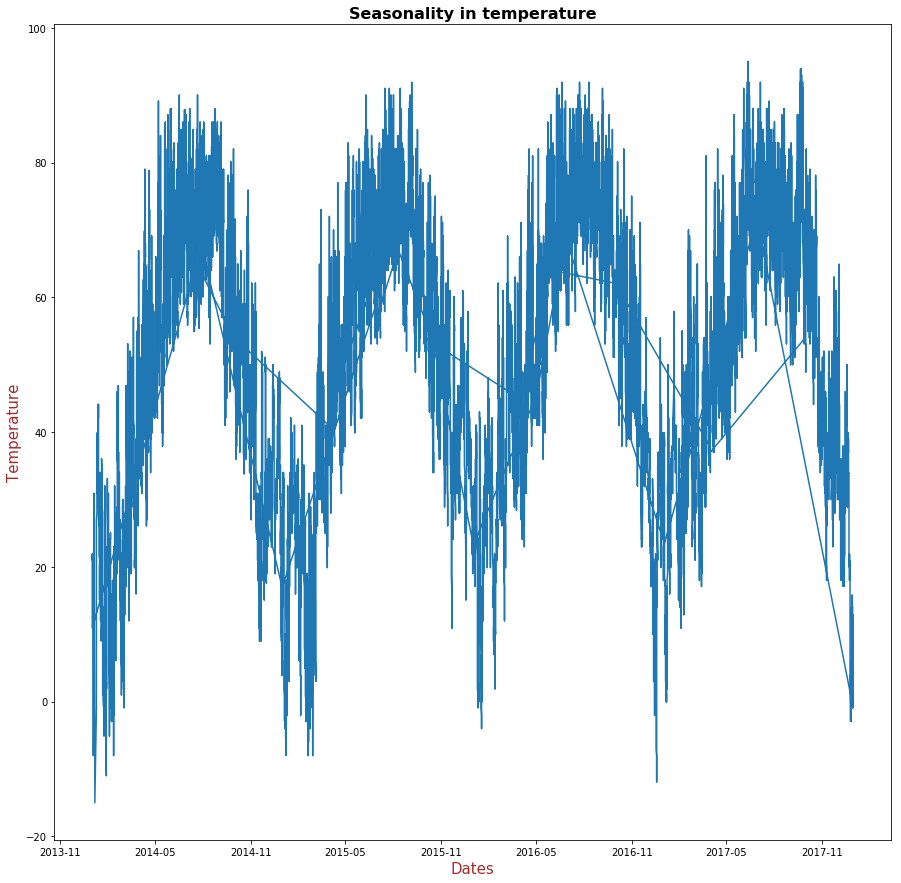

In [107]:
plt.figure(figsize=(15,15))
plt.plot(cycle['date'],cycle['temperature'])
plt.title("Seasonality in temperature", fontsize=16, fontweight='bold')
plt.xlabel("Dates",fontsize=15,color='brown')
plt.ylabel("Temperature",fontsize=15,color='brown')

plt.show()
plt.show()

Temperature shows similar behaviour to that of number of trips and trip duration. Now, we can convincingly conclude that temperature plays important role in bicycle trips.

In [158]:
monTemp=cycle.groupby(['month'])['temperature'].mean()
monTemp.index=[month[k] for k in monTemp.index]

In [177]:
smontemp=(monTemp-monTemp.mean())/(monTemp.std())
smonmean=(monMean-monMean.mean())/(monMean.std())
smon=(mon-mon.mean())/(mon.std())

Temperature, trip duration and number of trips have different ranges and so feature scaling is done by standardization of columns.

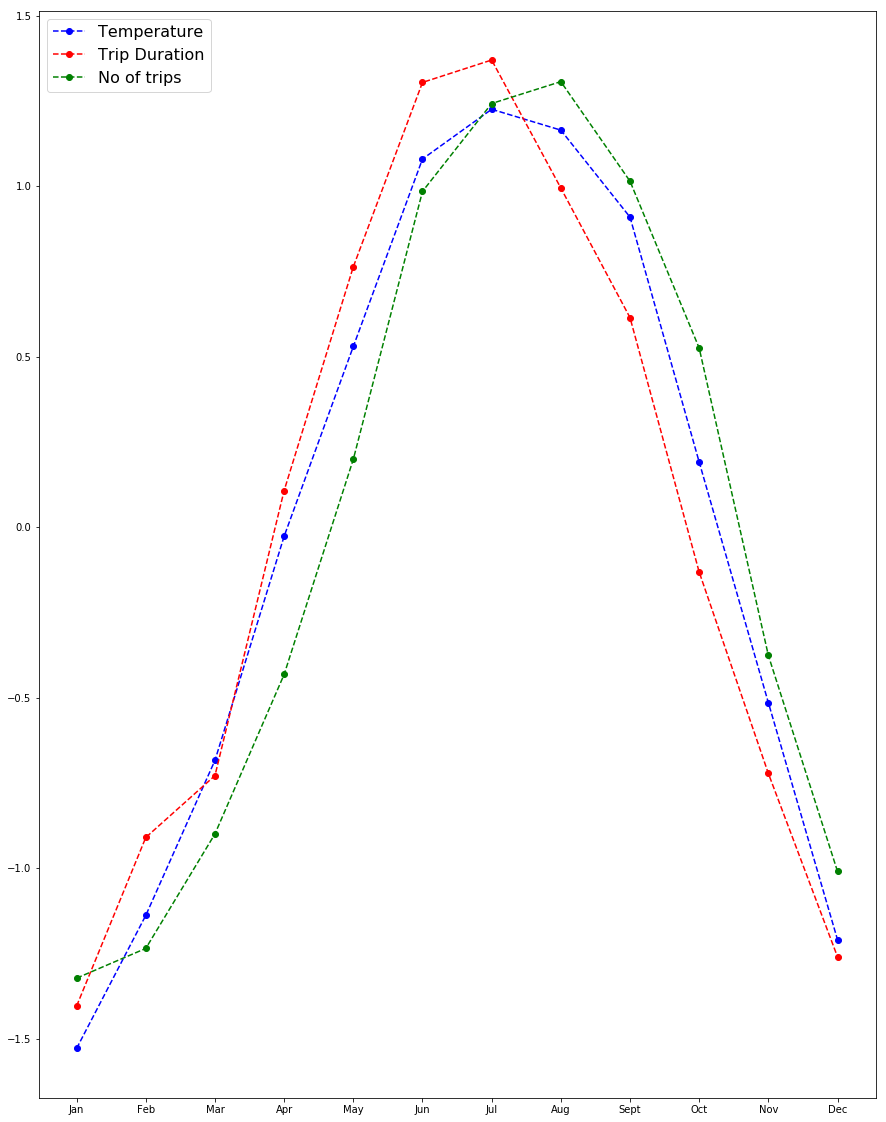

In [181]:
plt.figure(figsize=(15,20))
plt.plot(smontemp, linestyle='--', marker='o', color='b',label='Temperature')
plt.plot(smonmean, linestyle='--', marker='o', color='r',label='Trip Duration')
plt.plot(smon, linestyle='--', marker='o', color='g',label='No of trips')
plt.legend(loc="upper left",prop={'size': 16})

plt.show()

Line plots show that throughout the year, average trip duration and average number of trip follow similar pattern as of temperature

# Relation with the hour of day

In [68]:
hr=cycle.groupby(['hour']).size()
maleHr=cycle[cycle['gender']=='Male'].groupby(['hour']).size()
femaleHr=cycle[cycle['gender']=='Female'].groupby(['hour']).size()

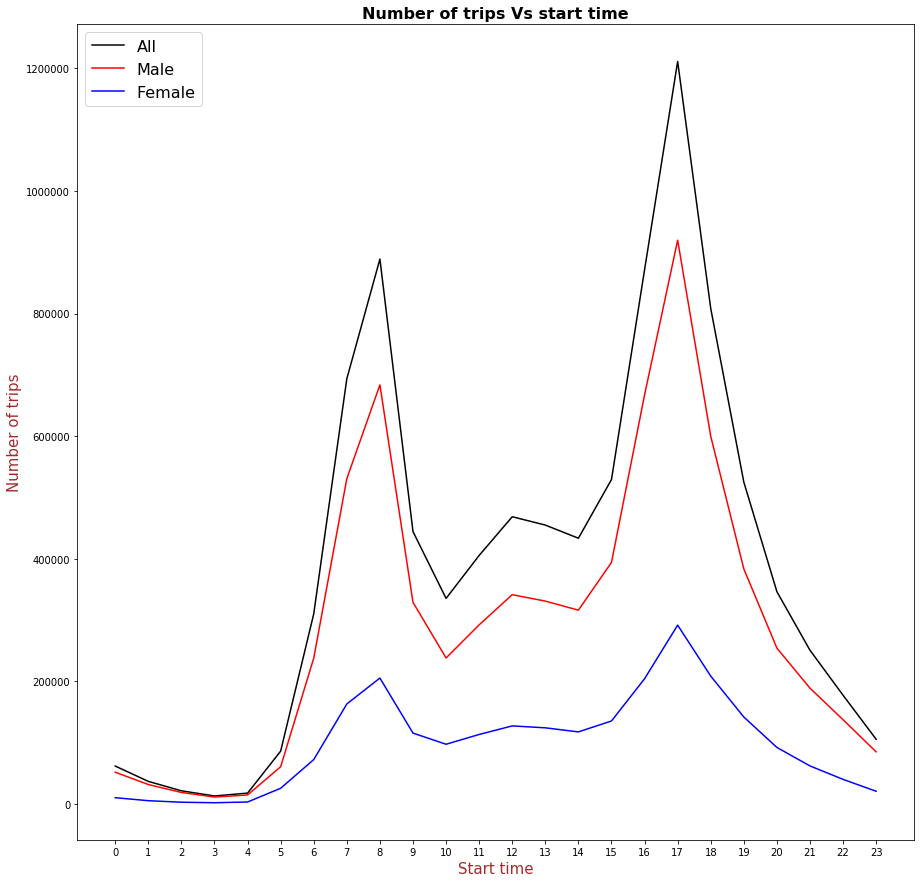

In [125]:
plt.figure(figsize=(15,15))
plt.plot(hr.index,hr,color='Black',label='All')
plt.plot(maleHr.index,maleHr,color='R',label='Male')
plt.plot(femaleHr.index,femaleHr,color='B',label='Female')
plt.title("Number of trips Vs start time", fontsize=16, fontweight='bold')
plt.xlabel("Start time",fontsize=15,color='brown')
plt.ylabel("Number of trips",fontsize=15,color='brown')
plt.legend(loc="upper left",prop={'size': 16})
plt.xticks(np.arange(min(cycle['hour']),max(cycle['hour'])+1,1))
plt.show()

Number of trips are higher in the morning and in the evening. People take bicycles to reach to travel back and forth from their places to offices. During evening, more people take bicycles which is good practice.

In [116]:
hrLen=cycle.groupby(['hour'])['tripduration'].mean()
maleHrLen=cycle[cycle['gender']=='Male'].groupby(['hour'])['tripduration'].mean()
femaleHrLen=cycle[cycle['gender']=='Female'].groupby(['hour'])['tripduration'].mean()

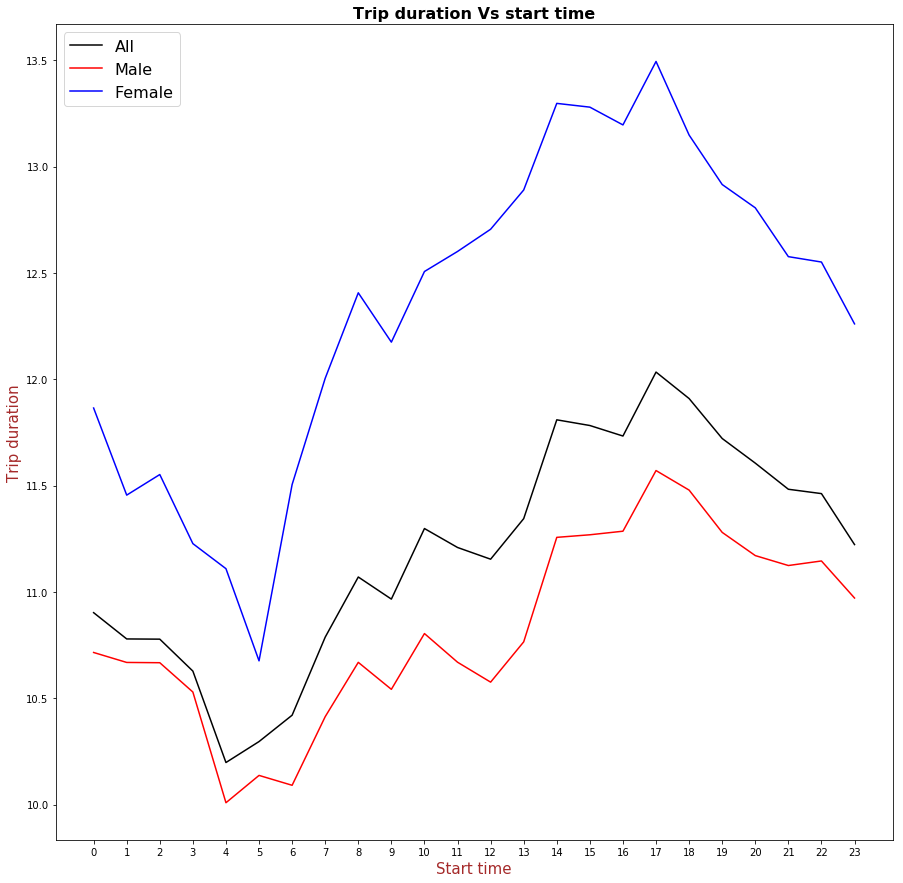

In [126]:
plt.figure(figsize=(15,15))
plt.plot(hrLen.index,hrLen,color='Black',label='All')
plt.plot(maleHrLen.index,maleHrLen,color='R',label='Male')
plt.plot(femaleHrLen.index,femaleHrLen,color='B',label='Female')
plt.title("Trip duration Vs start time", fontsize=16, fontweight='bold')
plt.xlabel("Start time",fontsize=15,color='brown')
plt.ylabel("Trip duration",fontsize=15,color='brown')
plt.legend(loc="upper left",prop={'size': 16})
plt.xticks(np.arange(min(cycle['hour']),max(cycle['hour'])+1,1))
plt.show()

Even though, number of trips are higher in the morning, the similar trend is not followed for duration of trips. During mornings, trip duration is much lower because people are in the rush to reach their work places. While, duration goes on increasing throughout the day and reached to almost 12 minutes (13.5 for females) in the evening. Considering gender, same trend is observed trhoughout the day as well.

In [114]:
hrdfs= dict(tuple(cycle.groupby('hour')))
data1=[]
lab1=[]
for k in hrdfs:
    data1.append(hrdfs[k]['temperature'])
    lab=str(k)
    lab1.append(lab)
        

/home/shreyas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


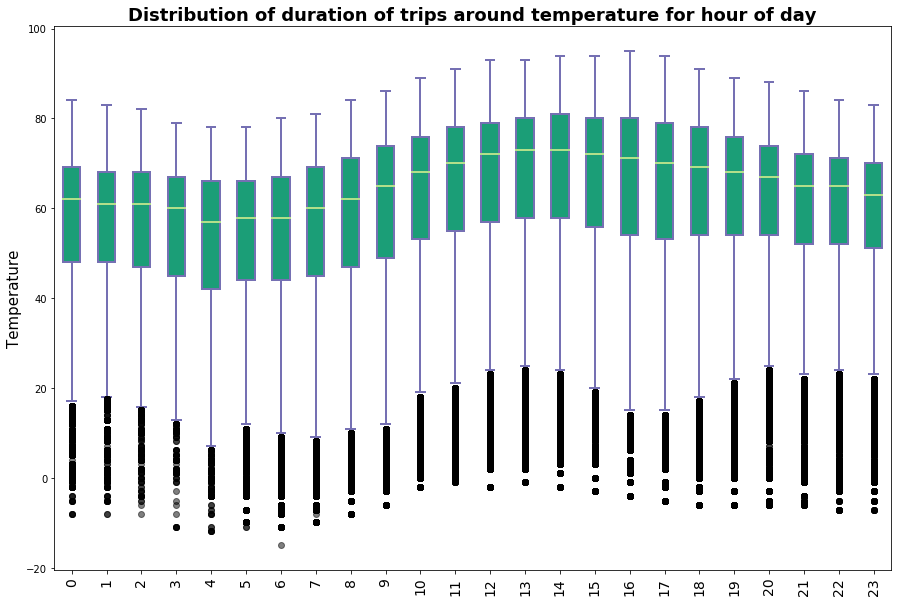

In [248]:
# Create a figure instance
fig = plt.figure(1, figsize=(15, 10))
ax = fig.add_subplot(111)
bp = ax.boxplot(data1, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)
ax.set_ylabel('Temperature',fontsize=15)
ax.set_ylabel('Hour of day',fontsize=15)

ax.set_title('Distribution of duration of trips around temperature for hour of day',fontsize=18,fontweight='bold')
ax.set_xticklabels(lab1,rotation='vertical',fontsize=14)
plt.show()

To check if trip duration during day has any relation with the temperature, we plotted box plot to observe distribution of temperature for every hour of day. 
<br>
The median temperature is highest during afternoon, while number of trips are less. So, clearly, during a day, temperature doesn't play any role for number of trips. While, for duration, similar trend is observed. 

### Effect of locations of the stations

In [9]:
locations = cycle[['latitude_start', 'longitude_start','from_station_name']]
locationlist = locations.values.tolist()
unique_locs = [list(x) for x in set(tuple(x) for x in locationlist)]
len(unique_locs)

1147

There are 1147 bicycle stations in chicago which is an interesting fact to understand why there are so many cycle users in the city. 

In [256]:
map = folium.Map([41.8781, -87.6298],width=1000,height=1100, zoom_start=12)
for point in range(0, len(unique_locs)):
    folium.Circle([unique_locs[point][0],unique_locs[point][1]], popup=unique_locs[point][2],radius=1).add_to(map)
map

Higher proportion of the stations are closer to the Michigen Lake. Proximity to the lake might play some role in the temperature. It might cause wind chills and so can affect bicycle trips. So, increasing stations away from lake can increase bicycle users. However, this is just a theory and data is insufficient to put forward some conclusive evidence.

### Conclusions:

To sum up the patterns we observed in the visualizations:<br><br>
1) Temperature affects trip duration and number of trips.<br>
2) People tend to take more bicycle rides during cloudy weather.<br>
3) Females take trips for more time than males.<br>
4) Trip duration and number of trips are much higher during summer than winter and intermediate during spring and fall.<br>
5) More stations are situated closer to the lake which can also affect trip duration.<br>
6) 3 out of 4 bicycle users are male.<br>